In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import scipy.signal as sp
import datetime as dt
from beam2ENU import beam2ENU
import seawater as sw
import oceans as oc

In [22]:
directory = '../../Data/deployment_raw/';
outdir = '../../plots/Ri/Ri_profile/';
deployment_name = 'deploy1_';
measurement_type = 'ctd_';
file_type = 'raw_'
profile = 0;
#Open the CTD data file that has all data stored as pandas
c_file = 'C'+("%07d" % (profile,))
a_file = 'A'+("%07d" % (profile,))
c_data = pd.read_pickle(directory+deployment_name+file_type+c_file)
a_data = pd.read_pickle(directory+deployment_name+file_type+a_file)

#Join CTD and ADCP data together (add time to CTD data)
start_time = a_data["a_time"].values[1][:-10]
start_time = dt.datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
start_time = start_time - dt.timedelta(seconds=15)
c_data["c_time"] = [start_time+dt.timedelta(seconds=x) for x in range(len(c_data["c_temp"].values))]
c_data.index = pd.DatetimeIndex(c_data['c_time'])

#And average ADCP to resample at 1Hz
a_data.index = pd.DatetimeIndex(a_data['a_time'])
a_data = a_data.resample('S').mean()
#Combine both datasets into one dataset by time
data = pd.concat([a_data, c_data], axis=1, sort=False).dropna(axis='rows')
#Combine both datasets into one dataset by time
data = pd.concat([a_data, c_data], axis=1, sort=False).dropna(axis='rows')
#Create east and north data
[east,north,up] = beam2ENU([data["a_beam1"][0],data["a_beam2"][0],data["a_beam3"][0],data["a_beam4"][0]],data['a_heading'].values,data['a_pitch'].values,data['a_roll'].values,data['a_vel1'].values,data['a_vel2'].values,data['a_vel3'].values)

C:\Users\jorly\Anaconda3\envs\wire3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


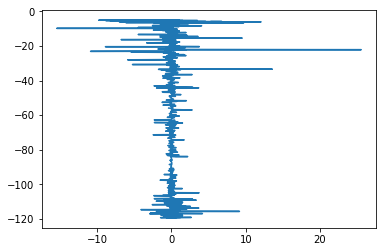

In [27]:
#Shear Magnitude method 1 
z = data['c_depth']
u = east
v = north
z, u, v = list(map(np.asanyarray, (z, u, v)))
z, u, v = np.broadcast_arrays(z, u, v)

m = z.shape[0]
iup = np.arange(0, m - 1)
ilo = np.arange(1, m)
z_ave = (z[iup] + z[ilo]) / 2.
vel = np.sqrt(u ** 2 + v ** 2)
diff_vel = np.diff(vel, axis=0)
diff_z = np.diff(z, axis=0)
shr = diff_vel / diff_z
#return shr, z_ave

#[shr, z_ave] = oc.sw_extras.shear(data['c_depth'].values,east,north)
plt.plot(shr,z_ave)
plt.show()

In [ ]:
#Shear Magnitude method 2